In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import csv
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as imputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import glob
from driver import stack_list, stack_labels, return_shapes, return_to_original, split_probs




In [2]:
df_list = []
labels = []

for f in sorted(glob.glob("training/" + "/*.psv")):
    df_list.append(pd.read_csv(f,sep='|'))
    labels.append(df_list[len(df_list)-1]["SepsisLabel"])
    

#Making sure that imputation does not removes the EtC02 column
#Also removing the sepsislable column from the original data
for i in df_list:
    i.iloc[0,i.columns.get_loc('EtCO2')] = 0
    i.drop('SepsisLabel', axis=1, inplace=True)
    
    
df_list2 = []
labels2 = []

for f in sorted(glob.glob("training_setB/" + "/*.psv")):
    df_list2.append(pd.read_csv(f,sep='|'))
    labels2.append(df_list2[len(df_list2)-1]["SepsisLabel"])
    
    
for i in df_list2:
    i.drop('SepsisLabel', axis=1 , inplace=True)

In [36]:
x_train = df_list
y_train = labels

x_test = df_list2
y_test = labels2

#Getting the datas original shapes before stacking tjem
train_shapes = return_shapes(x_train)
test_shapes = return_shapes(x_test)

#Normalizing and stacking the normalized data
x_train = stack_list(x_train)
x_train = (x_train-x_train.mean()) / x_train.std()
x_test = stack_list(x_test)
x_test = (x_test - x_test.mean()) / x_test.std()

y_train = stack_labels(y_train)
y_test = stack_labels(y_test) 


# #Shuffling the train data for better randomized result
# randomizer = np.random.permutation(len(x_train))
# x_train = x_train[randomizer]
# y_train = y_train[randomizer]

In [37]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
classifier.fit(x_train, y_train)

print('Creating the model is done ! Now commencing to the prediction part...')
predicted_labels = return_to_original(classifier.predict(x_test),test_shapes)
probabilities = split_probs(return_to_original(classifier.predict_proba(x_test),test_shapes))
real_values = return_to_original(y_test, test_shapes) 


print('This is the length of the predicted_labels list: {}'.format(len(predicted_labels)))
print('This is the length of the predicted_probabilities list: {}'.format(len(probabilities)))

print('*************************************************************************************************')
ran_val = np.random.randint(low=5, high= len(predicted_labels)-1)
print('This is the shape of predicted_labels for patient no {}: {}'.format(ran_val,predicted_labels[ran_val].shape))
print('This is the shape of predicted_probabilities for patient no {}: {}'.format(ran_val,probabilities[ran_val].shape))
print('And the real shape of this patient no {} is : {}'.format(ran_val,test_shapes[ran_val]))

Creating the model is done ! Now commencing to the prediction part...
This is the length of the predicted_labels list: 20000
This is the length of the predicted_probabilities list: 20000
*************************************************************************************************
This is the shape of predicted_labels for patient no 4121: (54,)
This is the shape of predicted_probabilities for patient no 4121: (54,)
And the real shape of this patient no 4121 is : 54


In [39]:
#Writing files to a directory under predictions
output_directory = "predictions"
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
else: 
    os.mkdir(output_directory)

for i,f in enumerate(predicted_labels):
    with open('predictions/p1%05d.psv' % i, 'w') as f:
        f.write('PredictedProbability|PredictedLabel\n')
        for(s,l) in zip(probabilities[i],predicted_labels[i]):
            f.write('%g|%d\n' % (s,l))
    

Plotting the data now...


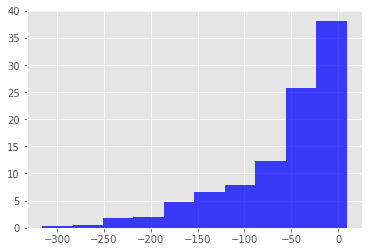

In [40]:
result = []
for i,k in enumerate(predicted_labels):
    result.append(detection_hour(real_values[i],k))

result = np.array(result)
result = result[result != None]
print("Plotting the data now...")
plt.hist(result, weights=100*np.ones_like(result) / len(result),
                            facecolor='blue', alpha=0.75);

20000
20000


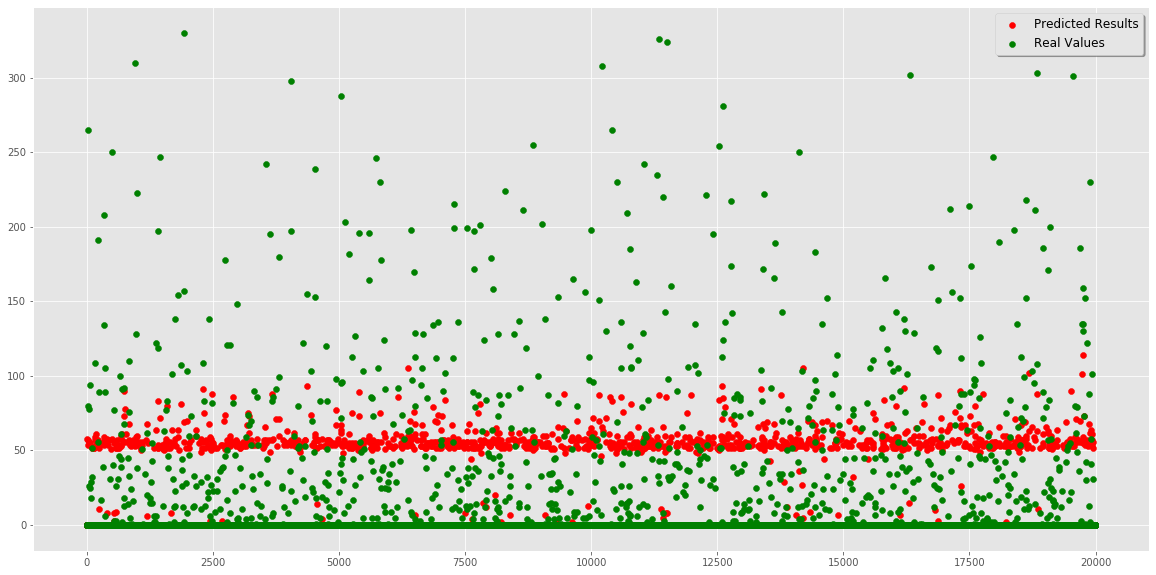

In [41]:
result = []
for i,k in enumerate(real_values):
    if np.max(k) == 1:
        result.append(np.argmax(k))
    else:
        result.append(0)

pre_result = []
for i,k in enumerate(predicted_labels):
    if np.max(k) == 1:
        pre_result.append(np.argmax(k))
    else:
        pre_result.append(0)





print(len(result))
print(len(pre_result))

plt.figure(figsize=(20,10))
plt.scatter(np.arange(len(pre_result)),pre_result, c = "r", label = "Predicted Results")
plt.scatter(np.arange(len(result)),result, c = "g", label= "Real Values")
plt.legend(loc='upper right', fontsize=12,fancybox=True, shadow=True)

plt.show()



In [6]:
#Returns the detection hour of the patient.
def detection_hour(label, prediction):
    if np.max(label) == 0 or np.max(prediction) == 0:
        return 
    
    real_time = np.argmax(label)
    prediction_time = np.argmax(prediction)
    
    return prediction_time - real_time
    
#Checks how many 0's present in the current list and prints it.
def check_list(list):
    counter = 0
    for i in list:
        if np.max(i) == 0:
            counter+= 1
        
    print(counter)
    
    return

In [15]:
def predict_outcomes():
    df_list = []
    labels = []

    for f in sorted(glob.glob("training/" + "/*.psv")):
        df_list.append(pd.read_csv(f,sep='|'))
        labels.append(df_list[len(df_list)-1]["SepsisLabel"])


    #Making sure that imputation does not removes the EtC02 column
    #Also removing the sepsislable column from the original data
    for i in df_list:
        i.iloc[0,i.columns.get_loc('EtCO2')] = 0
        i.drop('SepsisLabel', axis=1, inplace=True)


    df_list2 = []
    labels2 = []

    for f in sorted(glob.glob("training_setB/" + "/*.psv")):
        df_list2.append(pd.read_csv(f,sep='|'))
        labels2.append(df_list2[len(df_list2)-1]["SepsisLabel"])


    for i in df_list2:
        i.drop('SepsisLabel', axis=1 , inplace=True)


    x_train = df_list
    y_train = labels

    x_test = df_list2
    y_test = labels2

    #Getting the datas original shapes before stacking tjem
    train_shapes = return_shapes(x_train)
    test_shapes = return_shapes(x_test)

    #Normalizing and stacking the normalized data
    x_train = stack_list(x_train)
    x_train = (x_train-x_train.mean()) / x_train.std()
    x_test = stack_list(x_test)
    x_test = (x_test - x_test.mean()) / x_test.std()

    y_train = stack_labels(y_train)
    
    randomizer = np.random.permutation(len(x_train))
    x_train = x_train[randomizer]
    y_train = y_train[randomizer]

    classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
    classifier.fit(x_train, y_train)
    
    
    #Checking the dimensions of the data, as well as returning them to their original shapes
    predicted_labels = return_to_original(classifier.predict(x_test),test_shapes)
    probabilities = split_probs(return_to_original(classifier.predict_proba(x_test),test_shapes))
    

    print('This is the length of the predicted_labels list: {}'.format(len(predicted_labels)))
    print('This is the length of the predicted_probabilities list: {}'.format(len(probabilities)))

    ran_val = np.random.randint(low=5, high= len(predicted_labels)-1)
    print('This is the shape of predicted_labels for patient no {}: {}'.format(ran_val,predicted_labels[ran_val].shape))
    print('This is the shape of predicted_probabilities for patient no {}: {}'.format(ran_val,probabilities[ran_val].shape))
    print('And the real shape of this patient no {} is : {}'.format(ran_val,test_shapes[ran_val]))
    
    
    #Writing files to a directory under predictions
    output_directory = "predictions"
    if os.path.exists(output_directory):
        shutil.rmtree(output_directory)
        os.mkdir(output_directory)
    else: 
        os.mkdir(output_directory)

    for i,f in enumerate(predicted_labels):
        with open('predictions/p1%05d.psv' % i, 'w') as f:
            f.write('PredictedProbability|PredictedLabel\n')
            for(s,l) in zip(probabilities[i],predicted_labels[i]):
                f.write('%g|%d\n' % (s,l))
    
    print('Done')
    return 